##### Preprocessing and multilabel classification for lupus articles using neural networks.
### Import dataset

In [1]:
#Dataset import
from ipynb.fs.full.Dataset_preparation import *
#Dataset characteristics
lupus_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 988 entries, 0 to 1201
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   treatment                      988 non-null    int32  
 1   outcome                        988 non-null    int32  
 2   diagnosis                      988 non-null    int32  
 3   symptome                       988 non-null    int32  
 4   etiology                       988 non-null    int32  
 5   epidemiologic                  988 non-null    int32  
 6   not_categorised                988 non-null    float64
 7   orginal_article                988 non-null    int32  
 8   metanalysis_systematic_review  988 non-null    int32  
 9   case_report                    988 non-null    int32  
 10  letter_short_common            988 non-null    int32  
 11  review                         988 non-null    int32  
 12  text                           988 non-null    ob

### Import libraries

In [2]:
#Importing libraries to support glove file
from numpy import array
from numpy import asarray
from numpy import zeros
from matplotlib import pyplot

#importing pad_sequences for sequence from preprocessing class in keras library
from keras.preprocessing.sequence import pad_sequences
#Importing Tokenizer for text from preprocessing class in keras library   
from keras.preprocessing.text import Tokenizer

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, GlobalMaxPooling1D, LSTM, Conv1D, Conv2D,  Activation, Dropout, Input
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers.convolutional import MaxPooling1D
from keras.utils import plot_model

#Importing Adam from optimizers class in keras library
from keras.optimizers import Adam

#Importing ReduceLROnPlateau, EarlyStopping, ModelCheckpoint from callback function in keras library
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

#Importing tensorflow
import tensorflow as tf

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import re
nltk.download('wordnet')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tress\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Tress\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Pre processing of dataset
     Change to lower case
     Remove common punctuation and chars
     Lemmatization 

In [3]:
lst_stopwords = nltk.corpus.stopwords.words("english")
def preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

#Perform cleansing of text (preprocess_text)
lupus_dataset[['text']]=lupus_dataset[['text']].apply(lambda row: preprocess_text(row['text'],flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords),axis=1)
x=lupus_dataset['text']
lupus_dataset.head()
labels = sorted(target_variables)

 ### GloVe Embedding 
 

In [4]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(lupus_dataset['text'])
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(lupus_dataset['text'])

# pad documents to a max length of 200 words
max_length = 200
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt',encoding="utf8")
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

print('Loaded %s word vectors.' % len(embeddings_dictionary))
#Creating an object named as 'embedding_matrix' and assigning it matrix of zeros
embedding_matrix = zeros((vocab_size, 100))
#Creating For loop to get the weight of words in the dict.
for word, index in t.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector



Loaded 400000 word vectors.


#### Define Metrics for evaluation

In [6]:
#Evaluation 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, hamming_loss
ModelsPerformance = {}

def metricsReport(modelName, test_labels, predictions):
    acc=accuracy_score(test_labels, predictions)
    precision=precision_score(test_labels, predictions,average='weighted')
    recall=recall_score(test_labels, predictions,average='weighted')
    macro_f1 = f1_score(test_labels, predictions, average='macro')
    micro_f1 = f1_score(test_labels, predictions, average='micro')   
    hamLoss = hamming_loss(test_labels, predictions)
    print(modelName,acc,precision,recall,macro_f1,micro_f1,hamLoss )

### Data Modelling using GloVe Embedding and DNN Multilabel Classification

Epoch 1/26
56/56 [==============================] - 3s 25ms/step - loss: 0.5410 - accuracy: 0.1734 - auc: 0.6435 - val_loss: 0.4065 - val_accuracy: 0.3884 - val_auc: 0.7984
Epoch 2/26
56/56 [==============================] - 1s 22ms/step - loss: 0.3941 - accuracy: 0.2655 - auc: 0.7887 - val_loss: 0.3666 - val_accuracy: 0.3823 - val_auc: 0.8336
Epoch 3/26
56/56 [==============================] - 1s 22ms/step - loss: 0.3593 - accuracy: 0.3096 - auc: 0.8374 - val_loss: 0.3499 - val_accuracy: 0.3639 - val_auc: 0.8649
Epoch 4/26
56/56 [==============================] - 1s 21ms/step - loss: 0.3151 - accuracy: 0.3340 - auc: 0.8810 - val_loss: 0.3265 - val_accuracy: 0.3792 - val_auc: 0.8790
Epoch 5/26
56/56 [==============================] - 1s 20ms/step - loss: 0.2888 - accuracy: 0.3217 - auc: 0.9024 - val_loss: 0.3207 - val_accuracy: 0.4037 - val_auc: 0.8753
Epoch 6/26
56/56 [==============================] - 1s 17ms/step - loss: 0.2751 - accuracy: 0.3632 - auc: 0.9128 - val_loss: 0.3154 - v

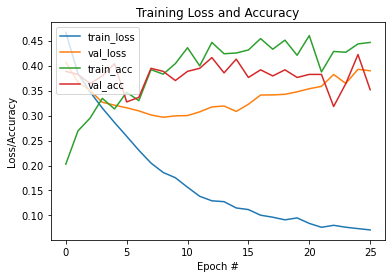

GloveEmbedding_DNN_Classfr 0.6973684210526315 0.9107239229809058 0.8012852199703411 0.7623043937596056 0.8567653276955604 0.04987118145012882


C:\Users\Tress\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
Glove_Emb= Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length)
 
labels = sorted(target_variables)
#Model layers
model_DNN = Sequential()
model_DNN.add(Glove_Emb)
model_DNN.add(Dense(126, activation='relu'))
model_DNN.add(Dropout(0.3))
model_DNN.add(GlobalMaxPooling1D())
model_DNN.add(Dense(64, activation='relu'))
model_DNN.add(Dropout(0.2))
model_DNN.add(Flatten())
model_DNN.add(Dense(11, activation='sigmoid'))

model_DNN.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.002,name='Adam'),
                  loss='binary_crossentropy',
                  metrics=['accuracy','AUC'])
#Split the dataset for training and validation.
X_train, X_test, y_train, y_test = train_test_split(padded_docs, lupus_dataset[labels], test_size=0.33,shuffle=True)
#Fit the model
history = model_DNN.fit(X_train, y_train,
                        epochs=26,
                        verbose=True,
                        validation_data=(X_test,y_test),
                        batch_size=12)

model_DNN.summary()

# plot metrics
from matplotlib import pyplot
pyplot.figure()

N = 26
pyplot.plot(np.arange(0, N), history.history["loss"], label="train_loss")
pyplot.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
pyplot.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
pyplot.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
pyplot.title("Training Loss and Accuracy")
pyplot.xlabel("Epoch #")
pyplot.ylabel("Loss/Accuracy")
pyplot.legend(loc="upper left")
pyplot.show()

results=[]
pred = model_DNN.predict(padded_docs)

#pred
# for i, p in enumerate(pred[0]):
#     results.append({labels[i]: p})
#     print({labels[i]: 1 if p>=0.5 else 0})

#Training Performance evaluation
def p_to_class(x):
    x=1 if x>=0.5 else 0
    return x 

pred_df=pd.DataFrame(data=pred,columns=labels)
Glove_DNN_pred=pred_df.applymap(p_to_class)
metricsReport('GloveEmbedding_DNN_Classfr',lupus_dataset[labels],Glove_DNN_pred)


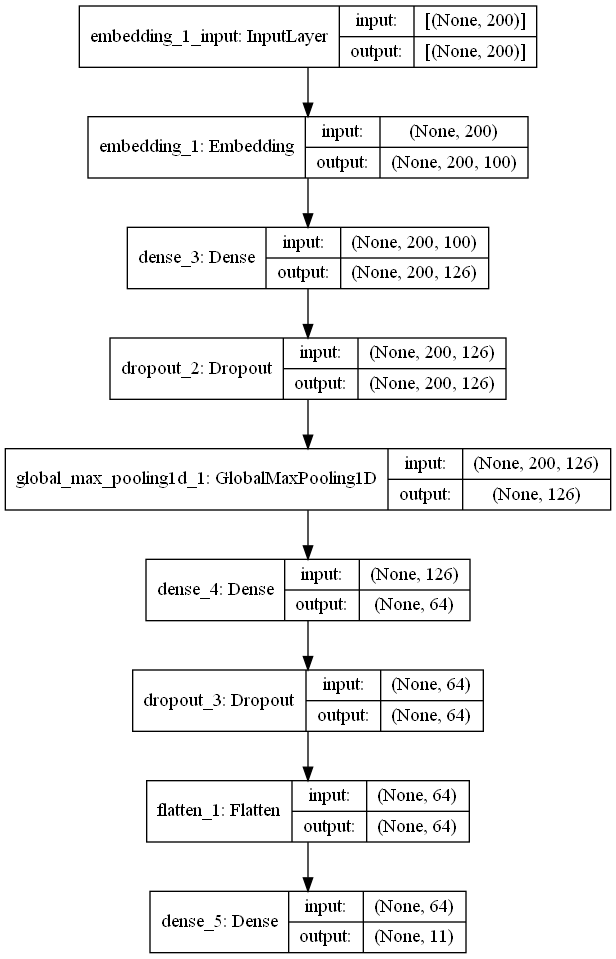

In [11]:
plot_model(model_DNN, to_file='model_plotDNN.png', show_shapes=True, show_layer_names=True)

#### Preprocessing for CNN Model

In [8]:
#Creating an object named 'tokenizer' for tokenizer function and inserting the num_words and lower keywords in it. 
tokenizer = Tokenizer(num_words=5000, lower=True)
tokenizer.fit_on_texts(lupus_dataset['text'])

#Creating an object named 'sequence' and fitting Text column from dataset in texts_to_sequences method 
sequences = tokenizer.texts_to_sequences(lupus_dataset['text'])

#Creating an object and assigning the numeric value of 200
maxlen = 200

#Creating an object named 'x' for pad_sequence and this variable will be further used as an input variable
x = pad_sequences(sequences, maxlen=maxlen)

#Creating an object named max_words and assigning lenght of tokens
max_words = len(tokenizer.word_index) + 1

#Creating an object named as 'embeddings_dictionary' and passing through it dict to convert into a dictonary 
embeddings_dictionary = dict()

#Already downloaded glove file to local system
#Creating an object named as 'glove_file' and importing glove file into it
glove_file = open('glove.6B.100d.txt', encoding="utf8")

#Implementing a for loop in glove file
#records: Splitting all the words
#word: adding words in list
#vector_dimensions: Converting the type into float32
#embeddings_dictionary: passing words into embeddings_dictionary
#glove_file.close: closing the glove file to avoid the error 
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

#Creating an object named as 'embedding_matrix' and assigning it matrix of zeros
embedding_matrix = zeros((max_words, 100))

#Creating For loop 
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

#### CNN Data Model

Epoch 1/30
83/83 [==============================] - 2s 21ms/step - loss: 0.5712 - accuracy: 0.1573 - val_loss: 0.4227 - val_accuracy: 0.1743
Epoch 2/30
83/83 [==============================] - 2s 20ms/step - loss: 0.4025 - accuracy: 0.2188 - val_loss: 0.3930 - val_accuracy: 0.3364
Epoch 3/30
83/83 [==============================] - 2s 19ms/step - loss: 0.3598 - accuracy: 0.3689 - val_loss: 0.3677 - val_accuracy: 0.3761
Epoch 4/30
83/83 [==============================] - 2s 19ms/step - loss: 0.3115 - accuracy: 0.3510 - val_loss: 0.3434 - val_accuracy: 0.3853
Epoch 5/30
83/83 [==============================] - 1s 18ms/step - loss: 0.2675 - accuracy: 0.3770 - val_loss: 0.3236 - val_accuracy: 0.3609
Epoch 6/30
83/83 [==============================] - 2s 19ms/step - loss: 0.2119 - accuracy: 0.4246 - val_loss: 0.3172 - val_accuracy: 0.3823
Epoch 7/30
83/83 [==============================] - 1s 18ms/step - loss: 0.1755 - accuracy: 0.4615 - val_loss: 0.3195 - val_accuracy: 0.3700
Epoch 8/30
83

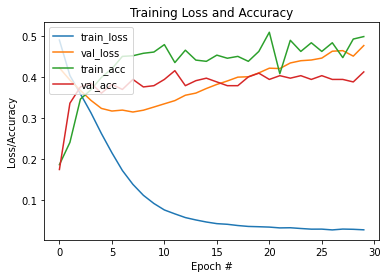

Model1_CNN_Classfr 0.6983805668016194 0.9338383572967657 0.791398912506179 0.7670496256475542 0.8602901665771091 0.04784688995215311


C:\Users\Tress\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
from matplotlib import pyplot
# load the dataset but only keep the top n words, zero the rest
top_words = 5000
embedding_vecor_length = 32
embedding_dim = 100
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index


results = []

#  Number of times that the algorithm should run : we can change it to 10 and get the average
num_of_iterations = 1
for j in range(0,num_of_iterations):

    model1 = Sequential()
    model1.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model1.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu')) 
    model1.add(GlobalMaxPooling1D())
#   model1.add(LSTM(256))
    model1.add(Dropout(0.2))

    model1.add(Dense(11, activation='sigmoid'))
    model1.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    X_train, X_test, y_train, y_test = train_test_split(x, lupus_dataset[labels], test_size=0.33,shuffle=True)
    history = model1.fit(X_train, y_train,
                        epochs=30,
                        verbose=True,
                        validation_data=(X_test, y_test),
                        batch_size=8)

    model1.summary()
# plot metrics
    
pyplot.figure()
N = 30
pyplot.plot(np.arange(0, N), history.history["loss"], label="train_loss")
pyplot.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
pyplot.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
pyplot.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
pyplot.title("Training Loss and Accuracy")
pyplot.xlabel("Epoch #")
pyplot.ylabel("Loss/Accuracy")
pyplot.legend(loc="upper left")
pyplot.show()

results=[]
pred = model1.predict(x)

#pred
# for i, p in enumerate(pred[0]):
#     results.append({labels[i]: p})
#     print({labels[i]: 1 if p>=0.5 else 0})

#Training Performance evaluation
def p_to_class(x):
    x=1 if x>=0.5 else 0
    return x 
pred_df=pd.DataFrame(data=pred,columns=labels)
Model1_pred=pred_df.applymap(p_to_class)
metricsReport('Model1_CNN_Classfr',lupus_dataset[labels],Model1_pred)


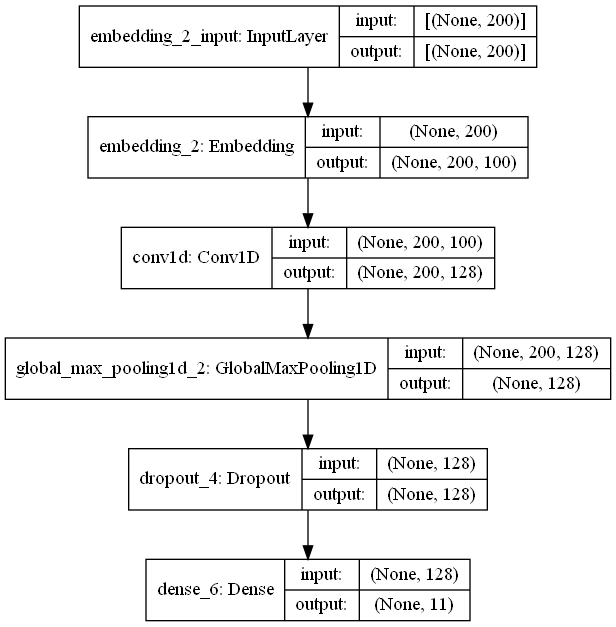

In [10]:
plot_model(model1, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)


#### Testing the models using 8 records

In [12]:
test_data=pd.read_excel('test_lupus.xlsx')
test_data.head()

,Text,treatment,outcome,diagnosis,symptome,etiology,epidemiologic,not_categorised,orginal_article,metanalysis_systematic_review,case_report,letter_short_common,review
0,Neuropsychiatric involvement in systemic lupus...,0,0,0,0,0,0,0,0,0,0,0,0
1,PECULIARITIES OF BONE MINERAL DENSITY IN WOMEN...,0,1,0,0,0,0,0,1,0,0,0,0
2,[Effect of COVID-19 confinement on the mental ...,0,1,0,1,0,0,0,1,0,0,0,0
3,Cerebellar ataxia as a primary manifestation o...,0,0,0,1,0,0,0,0,0,1,0,0
4,Antinuclear Antibody Testing for the Diagnosis...,0,0,1,0,0,0,0,0,0,0,0,1


#### Prepare the test for testing

In [13]:
encoded_test_docs = t.texts_to_sequences(test_data['Text'])
# pad documents to a max length of 200 words
padded_test_docs = pad_sequences(encoded_test_docs, maxlen=max_length, padding='post')
#print(padded_test_docs)

#### Test the DNN and CNN Models

In [14]:
#"Testing Performance" evaluation

##GLOVE DNN Pred
pred = model_DNN.predict(padded_test_docs)

pred_df=pd.DataFrame(data=pred,columns=labels)
Glove_DNN_pred=pred_df.applymap(p_to_class)
metricsReport('GloveEmbedding_DNN_Classfr',test_data[labels],Glove_DNN_pred)
print(Glove_DNN_pred)

##CNN Model 
pred = model1.predict(padded_test_docs)

#Testing Performance evaluation
pred_df=pd.DataFrame(data=pred,columns=labels)
Model1_pred=pred_df.applymap(p_to_class)
metricsReport('Model1_CNN_Classfr',test_data[labels],Model1_pred)
print(Model1_pred)

GloveEmbedding_DNN_Classfr 0.25 0.7388888888888889 0.5333333333333333 0.33030303030303027 0.5333333333333333 0.1590909090909091
   case_report  diagnosis  epidemiologic  etiology  letter_short_common  \
0            0          1              0         0                    0   
1            0          0              0         0                    0   
2            0          0              0         0                    0   
3            1          0              0         0                    0   
4            0          0              0         0                    0   
5            0          1              0         0                    0   
6            0          0              0         1                    0   
7            0          1              0         0                    0   

   metanalysis_systematic_review  orginal_article  outcome  review  symptome  \
0                              0                1        0       1         0   
1                              0    

C:\Users\Tress\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Tress\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Tress\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
C:\Users\Tress\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and 

#### Prediction of topics for recent articles. 

In [16]:
#Prepare text data 
test_data=pd.read_excel('test_cases_new.xlsx')
test_data.head()
encoded_test_docs = t.texts_to_sequences(test_data['Text'])
#print(encoded_test_docs)
# pad documents to a max length of 200 words
padded_test_docs = pad_sequences(encoded_test_docs, maxlen=max_length, padding='post')


#### Prediction Using GloVe Embedding DNN Multilabel Classification Model.

In [17]:

pred = model_DNN.predict(padded_test_docs)
#Testing Performance evaluation
pred_df=pd.DataFrame(data=pred,columns=labels)
Glove_DNN_pred=pred_df.applymap(p_to_class)

Glove_DNN_pred=pd.concat([Glove_DNN_pred, test_data], axis=1)
Glove_DNN_pred.to_csv('DNN_results.csv',index=True)
Glove_DNN_pred.head()

,case_report,diagnosis,epidemiologic,etiology,letter_short_common,metanalysis_systematic_review,orginal_article,outcome,review,symptome,treatment,Text
0,0,1,0,0,0,0,1,0,1,0,0,Neuropsychiatric involvement in systemic lupus...
1,0,0,0,0,0,0,1,0,0,0,0,PECULIARITIES OF BONE MINERAL DENSITY IN WOMEN...
2,1,0,0,0,0,0,0,0,0,1,0,Moyamoya angiopathy unmasking systemic lupus e...
3,0,0,0,0,0,0,1,1,0,0,0,[Clinical Features and Risk Factors of Systemi...
4,0,0,0,0,0,0,0,1,1,1,0,[Effect of COVID-19 confinement on the mental ...


#### Prediction Using CNN Multilabel Classification Model.

In [19]:
pred =  model1.predict(padded_test_docs)

#Testing Performance evaluation

pred_df=pd.DataFrame(data=pred,columns=labels)
CNN_pred=pred_df.applymap(p_to_class)
CNN_pred=pd.concat([CNN_pred, test_data], axis=1)
CNN_pred.to_csv('CNN_results.csv',index=True)
CNN_pred.head()

,case_report,diagnosis,epidemiologic,etiology,letter_short_common,metanalysis_systematic_review,orginal_article,outcome,review,symptome,treatment,Text
0,0,0,0,0,0,0,0,0,0,0,0,Neuropsychiatric involvement in systemic lupus...
1,0,0,0,0,0,0,1,0,0,0,0,PECULIARITIES OF BONE MINERAL DENSITY IN WOMEN...
2,0,0,0,0,0,0,0,0,0,0,0,Moyamoya angiopathy unmasking systemic lupus e...
3,0,0,0,0,0,0,1,0,0,0,0,[Clinical Features and Risk Factors of Systemi...
4,0,0,0,1,0,0,1,0,0,0,0,[Effect of COVID-19 confinement on the mental ...
